[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/movielens_skorch.ipynb)

In [ ]:
# !pip install tensorflow-gpu==2.0.0-beta1

In [1]:
%load_ext tensorboard

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, datetime
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/goodbooks-10k/'  # access from anywhere
path = 'data/goodbooks-10k/'  # if the files are local
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
df = pd.concat((train, test), ignore_index=True)

In [4]:
df.head()

,user_id,book_id,rating
0,26985,1,5
1,32332,1899,5
2,50054,3114,4
3,33313,2800,4
4,12666,1479,5


In [5]:
df.shape

(5976479, 3)

In [6]:
n_users = df.user_id.nunique()
n_items = df.book_id.nunique()
print('Number of users:', n_users)
print('Number of items:', n_items)

Number of users: 53424
Number of items: 10000


In [7]:
max_users = df.user_id.max()
max_items = df.book_id.max()
print("Max user ID:", max_users)
print("Max movie ID:", max_items)

Max user ID: 53423
Max movie ID: 9999


## Predict ratings

In [8]:
checkpoint_path = "models/goodbooks.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = ModelCheckpoint(checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

### Trunk of model
We will re-use the item embedding layer later on

In [36]:
logs_base_dir = "logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 10700), started 2:06:18 ago. (Use '!kill 10700' to kill it.)

In [10]:
# logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logs_base_dir, histogram_freq=1, embeddings_freq=1)

In [11]:
# item embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(max_items+1, 25, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(max_users+1, 25, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

### Head of model 
#### Option 1: dot product

In [12]:
# # dot product user and item vectors
# prod = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])

# # create model and compile it
# model = Model([user_input, item_input], prod)
# model.compile('adam', 'mean_squared_error')
# model.summary()

#### Option 2: neural network

In [13]:
from tensorflow.keras import backend as K

def stretch(x):
    return K.sigmoid(x) * (5 - 1) + 1

In [14]:
# concatenate features
conc = Concatenate()([item_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(64, activation='relu')(conc)
d1 = Dropout(.5)(fc1)
fc2 = Dense(32, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
out = Dense(1, activation=stretch)(d2)

# create model and compile it
model = Model([user_input, item_input], out)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 25)        250000      Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 25)        1335600     User-Input[0][0]                 
______________________________________________________________________________________________

In [15]:
model.load_weights(checkpoint_path)

In [19]:
len(df) / 256

23345.62109375

Train on 4781183 samples, validate on 1195296 samples
4780544/4781183 [============================>.] - ETA: 0s - loss: 0.6668
Epoch 00001: saving model to models/goodbooks.ckpt
4781183/4781183 [==============================] - 427s 89us/sample - loss: 0.6668 - val_loss: 0.6909


Text(0, 0.5, 'Training Error')

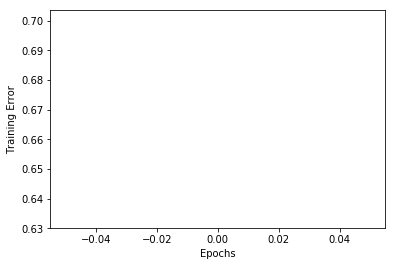

In [20]:
history = model.fit([df.user_id, df.book_id], df.rating, 
                    batch_size=256,
                    epochs=1,
                    verbose=1,
                    validation_split=.2,
                    callbacks=[cp_callback, tensorboard_callback])

plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [21]:
model.evaluate([df.user_id, df.book_id], df.rating, batch_size=1024)

5976479/5976479 [==============================] - 29s 5us/sample - loss: 0.6437


0.6436596912644581

In [14]:
np.sqrt(0.6980)

0.8354639429682169

In [23]:
predictions = model.predict([df.user_id.head(10), df.book_id.head(10)])

[print(predictions[i], df.rating.iloc[i]) for i in range(0,10)]

[4.7471237] 5
[4.148156] 5
[3.863347] 4
[3.5951762] 4
[4.452484] 5
[3.645379] 3
[4.365432] 5
[3.7191439] 5
[4.4383307] 5
[4.740861] 4


[None, None, None, None, None, None, None, None, None, None]

## Predict genres

In [26]:
books = pd.read_csv(path+'books.csv')

In [35]:
new_index = pd.Index(np.arange(0,10000,1), name="book_id")
books.set_index("book_id").reindex(new_index).reset_index().to_csv('data/goodbooks-10k/books.tsv', sep='\t')

In [27]:
books.head()

,book_id,original_title,language_code,adult,adult-fiction,adventure,book-club,contemporary,fantasy,fiction,mystery,romance,young-adult
0,0,The Hunger Games,eng,0,0,1,1,1,1,1,0,1,1
1,1,Harry Potter and the Philosopher's Stone,eng,0,0,1,0,1,1,1,1,0,1
2,2,Twilight,en-US,0,0,0,1,1,1,1,0,0,1
3,3,To Kill a Mockingbird,eng,1,1,0,1,1,0,1,1,0,1
4,4,The Great Gatsby,eng,1,1,0,1,0,0,1,0,1,1


In [23]:
# check proprtions of each genre
books.iloc[:,3:].agg('sum')/len(books)

adult            0.681176
adult-fiction    0.492522
adventure        0.377617
book-club        0.450232
contemporary     0.545333
fantasy          0.439299
fiction          0.938319
mystery          0.380196
romance          0.438473
young-adult      0.374420
dtype: float64

In [28]:
books.shape

(9695, 13)

In [25]:
# make new genre model
fc1 = Dense(16, activation='relu')(item_vec)
d1 = Dropout(.25)(fc1)
fc2 = Dense(8, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
genre_out = Dense(10, activation='sigmoid')(d2)

# Create model and compile it
model2 = Model(item_input, genre_out)
# freeze the embedding layer
model2.layers[1].trainable = False
model2.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Item-Input (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
Item-Embedding (Embedding)   (None, 1, 25)             250000    
_________________________________________________________________
Flatten-Items (Flatten)      (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                416       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0   

W0711 22:05:23.534866 10376 deprecation.py:323] From C:\Users\jlesl\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7756 samples, validate on 1939 samples
Epoch 1/10
7756/7756 [==============================] - 1s 190us/sample - loss: 0.6836 - accuracy: 0.5687 - val_loss: 0.6649 - val_accuracy: 0.6363
Epoch 2/10
7756/7756 [==============================] - 1s 102us/sample - loss: 0.6545 - accuracy: 0.6216 - val_loss: 0.6333 - val_accuracy: 0.6539
Epoch 3/10
7756/7756 [==============================] - 1s 103us/sample - loss: 0.6298 - accuracy: 0.6385 - val_loss: 0.6187 - val_accuracy: 0.6524
Epoch 4/10
7756/7756 [==============================] - 1s 109us/sample - loss: 0.6204 - accuracy: 0.6429 - val_loss: 0.6141 - val_accuracy: 0.6544
Epoch 5/10
7756/7756 [==============================] - 1s 105us/sample - loss: 0.6141 - accuracy: 0.6508 - val_loss: 0.6102 - val_accuracy: 0.6604
Epoch 6/10
7756/7756 [==============================] - 1s 109us/sample - loss: 0.6110 - accuracy: 0.6514 - val_loss: 0.6086 - val_accuracy: 0.6604
Epoch 7/10
7756/7756 [==============================] - 1s 110us

Text(0, 0.5, 'Training Error')

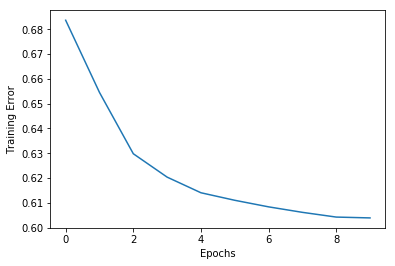

In [26]:
history = model2.fit(books.book_id, books.iloc[:,-10:], 
                     batch_size=64, 
                     epochs=10,
                     validation_split=.2,
                     callbacks=[tensorboard_callback])

plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [27]:
model2.evaluate(books.book_id, books.iloc[:,-10:], batch_size=128)

9695/9695 [==============================] - 0s 35us/sample - loss: 0.5935 - accuracy: 0.6731


[0.5935083103339779, 0.67312014]

In [28]:
# check predictions of first 10 books
np.round(model2.predict(books.book_id.head(10)))

array([[1., 0., 1., 0., 0., 1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 1., 0., 1., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0.]], dtype=float32)

## Check accuracy for only the romance tag

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [30]:
y_true = books.iloc[:,-10:]
y_score = pd.DataFrame(model2.predict(books.book_id), columns=y_true.columns)
y_pred = y_score.round().astype('int')

In [31]:
rom_true = y_true.romance
rom_pred = y_pred.romance

In [32]:
print(classification_report(rom_true, rom_pred))

              precision    recall  f1-score   support

           0       0.66      0.78      0.71      5444
           1       0.63      0.48      0.55      4251

   micro avg       0.65      0.65      0.65      9695
   macro avg       0.64      0.63      0.63      9695
weighted avg       0.64      0.65      0.64      9695



In [33]:
pd.DataFrame(confusion_matrix(rom_true, rom_pred))

,0,1
0,4229,1215
1,2201,2050


In [34]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(rom_true, y_score.iloc[:,-2])

In [35]:
prt_df = pd.DataFrame([thresholds, precision, recall]).T
prt_df.columns = ['threshold','precision','recall']
prt_df.head()

,threshold,precision,recall
0,0.208986,0.438971,1.000000
1,0.210909,0.438914,0.999765
2,0.211752,0.438959,0.999765
3,0.211878,0.439004,0.999765
4,0.211983,0.439050,0.999765


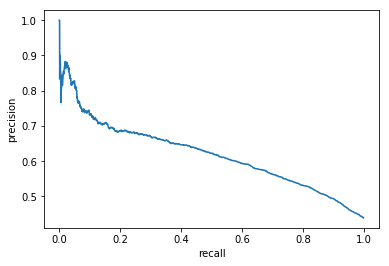

In [36]:
sns.lineplot(x=prt_df.recall,
             y=prt_df.precision)
plt.show()

### Global accuracy

In [37]:
(y_true == y_pred).astype('int').mean()

adult            0.681176
adult-fiction    0.593089
adventure        0.634863
book-club        0.714389
contemporary     0.638061
fantasy          0.616400
fiction          0.938319
mystery          0.641671
romance          0.647653
young-adult      0.625580
dtype: float64

In [38]:
from sklearn.metrics import accuracy_score, coverage_error
# how many perfectly classified rows
accuracy_score(y_true, y_pred)

0.04105208870551831

In [39]:
coverage_error(y_true, y_score)

7.64631253223311

In [40]:
print(classification_report(y_true, y_pred, target_names=y_true.columns))

               precision    recall  f1-score   support

        adult       0.68      1.00      0.81      6604
adult-fiction       0.57      0.68      0.62      4775
    adventure       0.55      0.20      0.29      3661
    book-club       0.68      0.68      0.68      4365
 contemporary       0.64      0.78      0.70      5287
      fantasy       0.58      0.45      0.51      4259
      fiction       0.94      1.00      0.97      9097
      mystery       0.58      0.20      0.30      3686
      romance       0.63      0.48      0.55      4251
  young-adult       0.00      0.00      0.00      3630

    micro avg       0.70      0.63      0.67     49615
    macro avg       0.59      0.55      0.54     49615
 weighted avg       0.63      0.63      0.61     49615
  samples avg       0.70      0.66      0.65     49615



C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
(y_true == y_pred).astype('int').mean().mean()

0.6731201650335226

In [42]:
f1_score(y_true, y_pred, average='micro')

0.6652653815685239

### Precision and Recall

In [43]:
recall_score(y_true, y_pred, average='micro')

0.6347274009876046

In [44]:
precision_score(y_true, y_pred, average='micro')

0.6988903683976919

## Visualise embeddings

In [45]:
item_em = model2.get_layer('Item-Embedding')
item_em_weights = item_em.get_weights()[0]

In [46]:
item_em_weights.shape

(10000, 25)

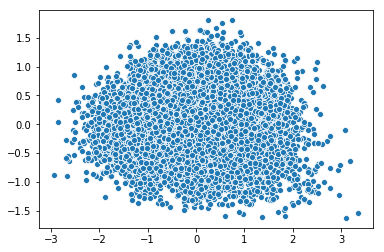

In [47]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [48]:
item_em_weights = item_em_weights / np.linalg.norm(item_em_weights, axis = 1).reshape((-1, 1))
item_em_weights[0][:10]
np.sum(np.square(item_em_weights[0]))

1.0

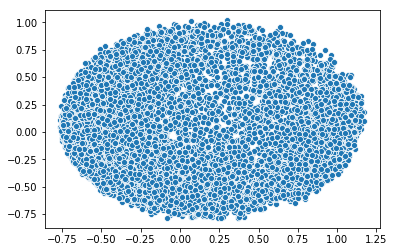

In [49]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [50]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1)
tnse_results = tsne.fit_transform(item_em_weights)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 5.912s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.189659
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.836250
[t-SNE] KL divergence after 1000 iterations: 2.566676


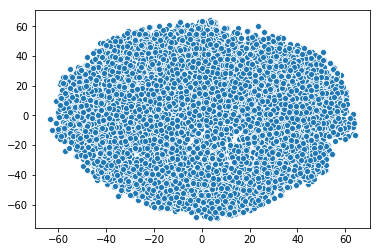

In [51]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Making recommendations

In [52]:
# Creating dataset for making recommendations for the first user
item_data = np.array(list(set(train.book_id)))
item_data[:5]

array([0, 1, 2, 3, 4])

In [53]:
user = np.array([1 for i in range(len(item_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [54]:
predictions = model.predict([user, item_data])

predictions = np.array([a[0] for a in predictions])

# get top 5 predictions
recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

array([3627, 7946, 6360, 1787, 8945], dtype=int64)

In [55]:
# print predicted scores
predictions[recommended_book_ids]

array([4.992871 , 4.989388 , 4.9856462, 4.9843526, 4.9833755],
      dtype=float32)

In [56]:
books[books['book_id'].isin(recommended_book_ids)]

,book_id,original_title,language_code,adult,adult-fiction,adventure,book-club,contemporary,fantasy,fiction,mystery,romance,young-adult
1771,1787,The Calvin and Hobbes Tenth Anniversary Book,eng,0,0,1,0,0,1,1,0,0,1
3567,3627,The Complete Calvin and Hobbes,eng,0,0,0,0,0,1,1,0,0,1
6204,6360,There's Treasure Everywhere: A Calvin and Hobb...,eng,1,0,1,0,0,1,1,0,0,1
7721,7946,NaN,eng,1,0,0,0,0,0,0,0,0,0
8682,8945,دیوان‎‎ [Dīvān],eng,0,0,0,0,0,0,1,0,0,0
